# Learn Azure Synapse Data Explorer
## Chapter 6 - Data analysis with KQL, Python and Power BI
### Exploring Data Explorer pool data with PySpark on Azure Synapse

In this notebook, we will use PySpark to retrieve data from our **Drone Telemetry** database on the Data Explorer pool, run through some examples on how to explore data using Azure Synapse notebooks. 

#### Library imports and data retrieval 
#### 
First, we will import the Python libraries that we will use in this notebook. Here's how they will be used: 

- MatplotLib: we will use the popular Python library to plot some charts in the bottom of the %notebook
- NumPy: used in this notebook to perform some matrix-wide mathematical computations
- Pandas: will be used to handle data when plotted with Matplotlib

Next, we will select all the data from the fleet data table and store it in memory on a Spark DataFrame which we will call **df**. 

Finally, we will display the DataFrame to glance at the data and make sure everything worked. 


In [55]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.types import DateType
import seaborn 

mpl.rcParams['agg.path.chunksize'] = 10000

df  = spark.read \
    .format("com.microsoft.kusto.spark.synapse.datasource") \
    .option("spark.synapse.linkedService", "kustoPool") \
    .option("kustoCluster", "https://droneanalyticsadx.drone-analytics.kusto.azuresynapse.net") \
    .option("kustoDatabase", "drone-telemetry") \
    .option("kustoQuery", "['fleet data']") \
    .load()

display(df)

StatementMeta(sparkdronetl, 5, 55, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4c34325a-9eef-44c1-9450-c4211c971f1f)

#### Printing information about the data frame
#### 
The Pandas library offers a convenient way to print details about data frames using the _info()_ method. We will convert our Spark DataFrame to a Pandas DataFrame and run the _info()_ method to print index dtype and columns, non-null values and memory usage of the data frame. 



In [56]:
df.toPandas().info()

StatementMeta(sparkdronetl, 5, 56, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342594 entries, 0 to 342593
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DeviceData        342594 non-null  object        
 1   DateTime          342594 non-null  datetime64[ns]
 2   LocalDateTime     342594 non-null  datetime64[ns]
 3   DeviceState       342594 non-null  object        
 4   Engine1Status     342594 non-null  object        
 5   Engine2Status     342594 non-null  object        
 6   Engine3Status     342594 non-null  object        
 7   Engine4Status     342594 non-null  object        
 8   Engine1RPM        342594 non-null  int64         
 9   Engine2RPM        342594 non-null  int64         
 10  Engine3RPM        342594 non-null  int64         
 11  Engine4RPM        342594 non-null  int64         
 12  Engine1Temp       342594 non-null  int64         
 13  Engine2Temp       342594 non-null  int64         
 14  Engi

#### Obtaining Measures of central tendency
#### 
Computing the measures of central tendency is a simple task too. You can use the agg function of Spark DataFrames and pass as parameters the column which you want to compute, plus the op parameter. You can also use sum, stdev, max and other operators with the agg function. 

In [69]:
temp_avg = df.toPandas()['CoreTemp'].mean()
temp_median = df.toPandas()['CoreTemp'].median()
temp_mode = df.toPandas()['CoreTemp'].mode()
print('Average: ',temp_avg)
print('Median: ',temp_median)
print('Mode(s): ',int(temp_mode.to_string(index=False)))

StatementMeta(sparkdronetl, 5, 69, Finished, Available)

Average:  20.99016036474661
Median:  19.0
Mode(s):  18


In [71]:
df.agg({'CoreTemp': 'avg'}).show()

StatementMeta(sparkdronetl, 5, 71, Finished, Available)

+-----------------+
|    avg(CoreTemp)|
+-----------------+
|20.99016036474661|
+-----------------+



If you would like to see the average temperature grouped by a certain other column, such as DeviceState, you can do that by using dataframe.groupby(). 

In [58]:
df.groupby('DeviceState').avg('CoreTemp').sort('DeviceState').show(truncate=False)

StatementMeta(sparkdronetl, 5, 58, Finished, Available)

+-----------+------------------+
|DeviceState|avg(CoreTemp)     |
+-----------+------------------+
|Cruise     |21.422742322488975|
|Delivery   |21.464723063318953|
|Descent    |21.578897338403042|
|DeviceError|21.139956172388604|
|Off        |21.49317529698855 |
|On         |16.953545166657722|
|TakeOff    |21.481872787729273|
+-----------+------------------+



#### Plotting charts
#### 
To finalize, we will plot some charts to see our data from a few different angles. 

We will start by plotting a bell curve, which shows the normal distribution of the CoreTemp data. The bell curve helps what your the mean value of your data is, with all the other values symmetrically distributed around the mean. Plotting the bell curve requires us to compute the probability density function (known as PDF) for the values in the CoreTemp column. The PDF calculates, for a value at any given sample, the relative likelihood that the variable would be close to the value in the sample. Some Python packages, such as SciPy, provide libraries to compute the PDF for you, but we will simply plug in the values here to avoid importing a package only for this need. 

The formula of the PDF is:

![image-alt-text](https://th.bing.com/th/id/R.7954f230bef55eec121723c830175627?rik=A7tEaUbGp21jWw&riu=http%3a%2f%2f38.media.tumblr.com%2ftumblr_lh2vjfMhkE1qaityko1_500.gif&ehk=6OGSxE16pX2atYRoUfbacshkxKuUXw9QSg%2fUkXcVqow%3d&risl=&pid=ImgRaw&r=0)

Once we compute the PDF, we will create a plot that uses the CoreTemp data in the X axis, and the values in the PDF in the Y axis. 

StatementMeta(sparkdronetl, 5, 59, Finished, Available)

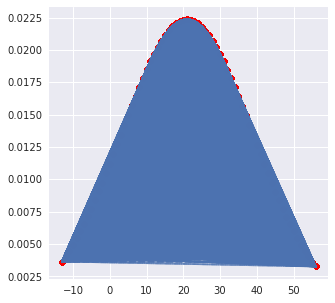

In [59]:
pandas_df = df.toPandas()

# Calculate the PDF 
meanTemp = pandas_df['CoreTemp'].mean()
stdTemp = pandas_df['CoreTemp'].std()
y =  1/(stdTemp * np.sqrt(2 * np.pi)) * np.exp( - (pandas_df['CoreTemp'] - meanTemp)**2 / (2 * stdTemp**2))

# Plot the bellcurve
plt.style.use('seaborn')
plt.figure(figsize = (5, 5))
plt.plot(pandas_df['CoreTemp'], y, linestyle = 'dashed', alpha=0.5)
plt.scatter(pandas_df['CoreTemp'], y, marker = 'o', s = 25, color = 'red')

Another helpul way to see the shape of your data is to plot a histogram. It allows you to see what are the most common values on your sample, and, why not, its distribution.

Plotting histograms on Python with Matplotlib is easy: 

StatementMeta(sparkdronetl, 5, 60, Finished, Available)

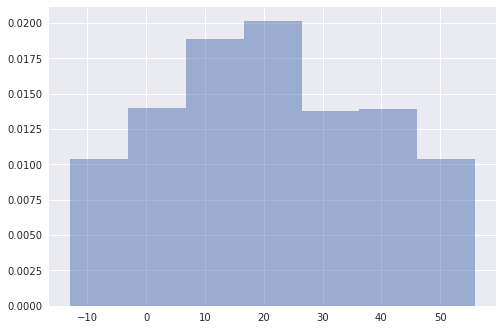

In [60]:
plt.hist(pandas_df['CoreTemp'], bins=7, alpha=0.5, density=True)
plt.show()

EXPLAIN BOXPLOTS HERE

StatementMeta(sparkdronetl, 5, 61, Finished, Available)

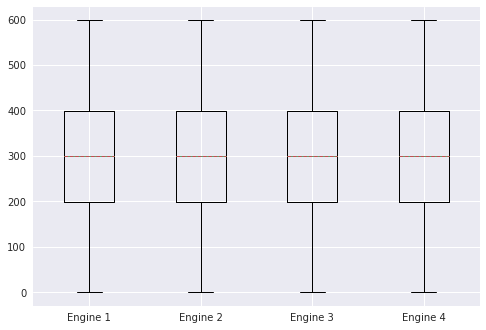

In [61]:
# Box plot, or whisker
plt.boxplot(pandas_df[['Engine1RPM','Engine2RPM','Engine3RPM','Engine4RPM']], meanline=True, showmeans=True)
plt.xticks([1,2,3,4], ['Engine 1','Engine 2','Engine 3','Engine 4'])
plt.show()

EXPLAIN CORRELATION MATRIX HERE

StatementMeta(sparkdronetl, 5, 62, Finished, Available)

<AxesSubplot:>

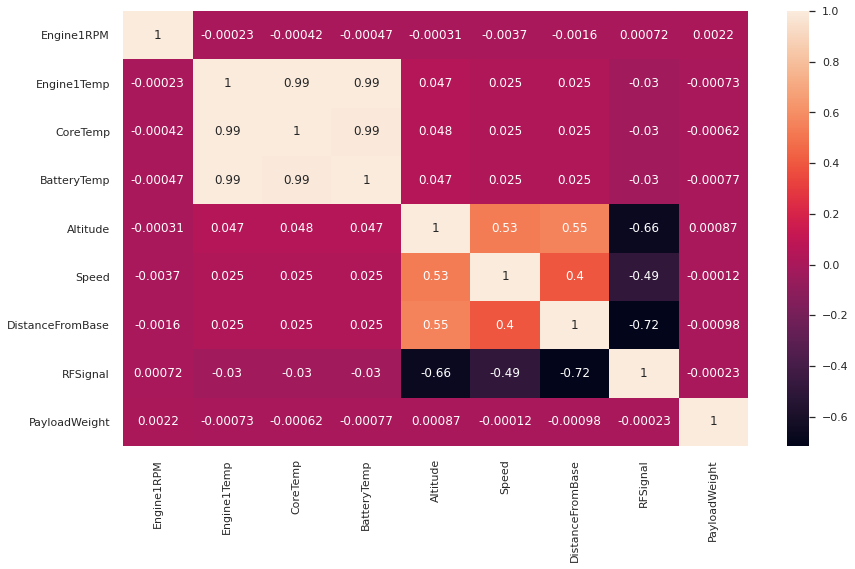

In [62]:
import seaborn 

correlation_matrix = pandas_df[['Engine1RPM','Engine1Temp','CoreTemp','BatteryTemp','Altitude',
                         'Speed','DistanceFromBase','RFSignal','PayloadWeight']].corr()
seaborn.set(rc = {'figure.figsize':(14, 8)})
seaborn.heatmap(correlation_matrix, annot=True)

#### Performing data transformations
#### 
It's very common to transform data before you present it to users, as sometimes the source data does not present user-frendly formats. Let's explore a couple of opportunities where we can transform data to make it more presentable to users. 

First, we will create a new LocalDate column which contains the date only (without the time) from the LocalDateTime column. This can make it easier for users to slice the data according by date without having to worry about filtering the time too. 

In [63]:
from pyspark.sql.types import DateType
df = df.withColumn('LocalDate', df['LocalDateTime'].cast(DateType()))
df.select('LocalDateTime','LocalDate').show(5, truncate=False)

StatementMeta(sparkdronetl, 5, 63, Finished, Available)

+--------------------------+----------+
|LocalDateTime             |LocalDate |
+--------------------------+----------+
|2021-09-27 09:46:10.342381|2021-09-27|
|2021-09-27 09:48:11.542381|2021-09-27|
|2021-09-27 09:56:42.293101|2021-09-27|
|2021-09-27 09:58:43.493101|2021-09-27|
|2021-09-27 10:00:17.573101|2021-09-27|
+--------------------------+----------+
only showing top 5 rows



Next, we will create a new column that shows the value of the CoreTemp column converted to Farenheit. This column will apply the following formula for conversion: 

```
Farenheit = Celsius * 1.8 + 32
```

In [64]:
from pyspark.sql.functions import round 
df = df.withColumn('CoreTemp-F', round(df['CoreTemp'] * 1.8 + 32,2))
df.select('CoreTemp','CoreTemp-F').show(5)

StatementMeta(sparkdronetl, 5, 64, Finished, Available)

+--------+----------+
|CoreTemp|CoreTemp-F|
+--------+----------+
|      11|      51.8|
|       3|      37.4|
|      21|      69.8|
|      43|     109.4|
|       4|      39.2|
+--------+----------+
only showing top 5 rows



In [65]:
from pyspark.sql.functions import col, get_json_object
df = df.withColumn('deviceName', get_json_object(col('DeviceData'),'$.deviceName').alias('deviceName'))
df = df.withColumn('accumulatedDistance', get_json_object(col('EventData'),'$.accumulatedDistance').alias('accumulatedDistance').cast('int'))
df.select('DeviceData','EventData','deviceName','accumulatedDistance').show(5)

StatementMeta(sparkdronetl, 5, 65, Finished, Available)

+--------------------+--------------------+----------+-------------------+
|          DeviceData|           EventData|deviceName|accumulatedDistance|
+--------------------+--------------------+----------+-------------------+
|{'guid': '90C5BED...|{'averageSpeed': ...| DT-F-725C|                  0|
|{'guid': '90C5BED...|{'averageSpeed': ...| DT-F-725C|                521|
|{'guid': '90C5BED...|{'averageSpeed': ...| DT-F-725C|               4693|
|{'guid': '90C5BED...|{'averageSpeed': ...| DT-F-725C|               5214|
|{'guid': '90C5BED...|{'averageSpeed': ...| DT-F-725C|               5214|
+--------------------+--------------------+----------+-------------------+
only showing top 5 rows



In [67]:
spark.sql('CREATE DATABASE IF NOT EXISTS drone_telemetry')
spark.sql('USE drone_telemetry')
df.write.mode('overwrite').saveAsTable('fleet_data')

StatementMeta(sparkdronetl, 5, 67, Finished, Available)